# Total 0-75

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('W:\COVID19\std_inz0_75_newnames.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_0to75']
X = df.loc[:, ~df.columns.isin(['std_inz_0to75', 'eastwest'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  162


# Feature Correlation

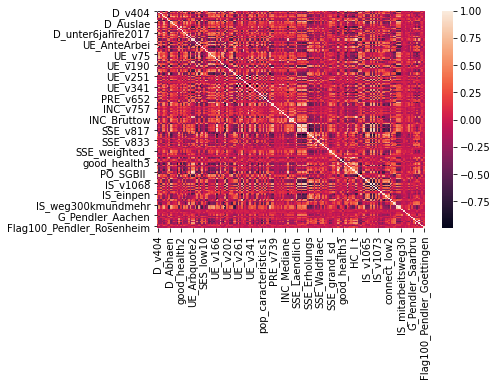

In [4]:
corr = X.corr()
sns.heatmap(corr)

pairs = []

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.8:
            pairs.append(corr.columns[[i,j]][0])
            pairs.append(corr.columns[[i,j]][1])
            print(corr.columns[[i,j]],corr.iloc[i,j])
            

len(pairs)
len(set(pairs))

In [6]:
#sns.heatmap(X[set(pairs)].corr())

# First CatBoost Model with 162 features

In [7]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9994066010320601


In [8]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  0.35100227312855303


# SHAP VAlues

In [9]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


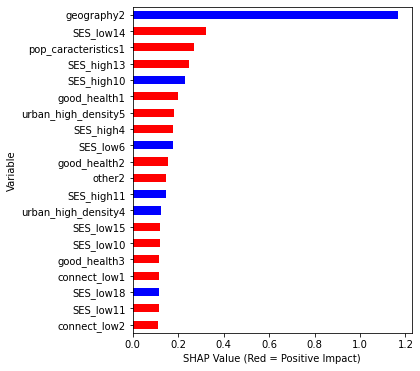

In [10]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

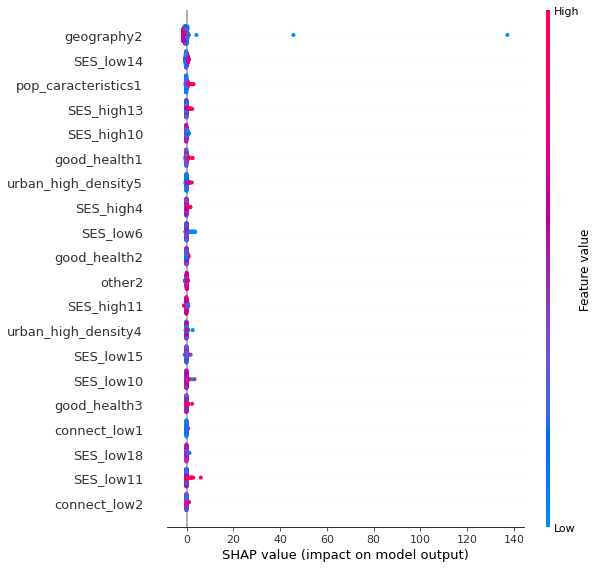

In [11]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [12]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [13]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9967381108684165


In [14]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  0.8229456113526061


# Compare top 10 features of both Models

In [15]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['geography2', 'SES_low14', 'pop_caracteristics1', 'SES_high13', 'SES_high10', 'good_health1', 'urban_high_density5', 'SES_high4', 'SES_low6', 'good_health2'] 

 10 most important features from model with top20 features: 
 ['geography2', 'SES_low6', 'urban_high_density5', 'pop_caracteristics1', 'SES_low14', 'SES_high10', 'SES_low10', 'SES_low18', 'other2', 'good_health1']


In [16]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

geography2
SES_low14
pop_caracteristics1
SES_high10
good_health1
urban_high_density5
SES_low6


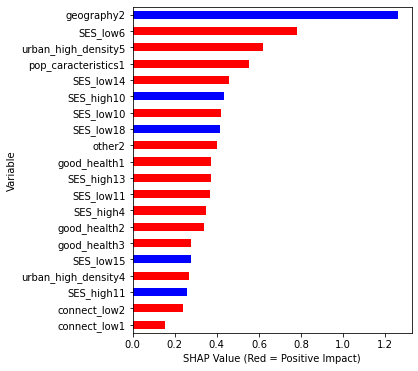

In [17]:
ABS_SHAP(shap_values_cb_20,X[top20feature]) 

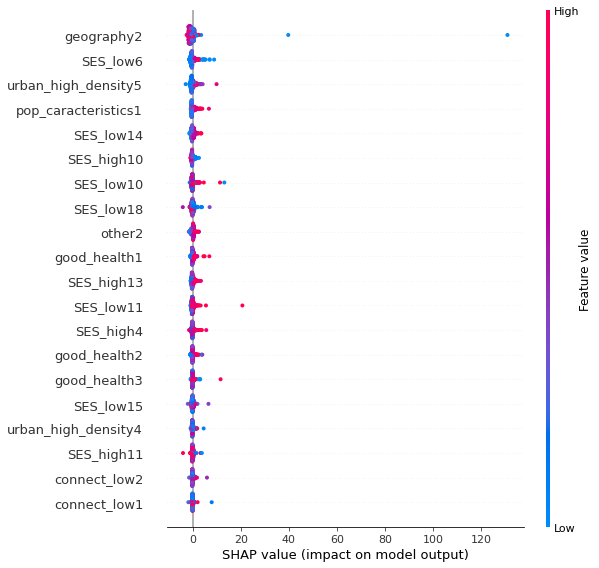

In [18]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [19]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [20]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9974167200478739
Mean R2 of linReg_modesl with top20 features:  0.14242663226213945
Mean RMSE of CatBoost_models on test sets with top20 features:  12.527680085446061
Mean R2 of CatBoost_models on test sets with top20 features: -0.16930538471009346


# descriptives of top20 features

In [21]:
X[top20feature].describe()

,geography2,SES_low14,pop_caracteristics1,SES_high13,SES_high10,good_health1,urban_high_density5,SES_high4,SES_low6,good_health2,other2,SES_high11,urban_high_density4,SES_low15,SES_low10,good_health3,connect_low1,SES_low18,SES_low11,connect_low2
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,9.866996,12.901742,32.242809,2.814465,5.259102,80.655960,33367.324219,14.988533,13.063090,23.700602,16.510975,32.202751,5.101742,34.556618,52.529175,50.857368,11.857856,20.240156,5.669324,22.563591
std,2.026269,2.768405,24.361435,3.325890,2.706737,1.012629,30681.785156,4.460500,6.197584,0.656121,8.783781,8.077894,3.710643,13.284163,3.597842,6.518343,8.366137,4.537329,9.243236,16.033613
min,6.083333,6.100000,1.700000,-7.200000,1.400000,77.860001,1062.000000,1.000000,5.600000,22.020000,-9.600000,10.500000,0.900000,4.600000,40.400002,28.600000,0.000000,10.800000,-22.299999,0.000000
25%,8.216666,11.100000,7.900000,0.500000,2.900000,80.010002,15678.000000,12.600000,8.900000,23.270000,11.700000,25.600000,2.700000,26.100000,50.500000,46.400002,6.000000,17.000000,1.000000,13.000000
50%,9.766666,12.900000,29.100000,3.100000,4.900000,80.629997,24587.000000,15.000000,10.900000,23.680000,17.600000,32.700001,4.300000,32.000000,52.700001,51.099998,10.000000,19.299999,8.500000,23.000000
75%,11.416667,14.800000,52.299999,5.100000,6.600000,81.440002,39522.000000,17.700001,15.000000,24.180000,21.900000,38.500000,6.300000,41.400002,55.099998,55.599998,15.000000,22.400000,12.000000,32.000000
max,14.983334,21.900000,87.800003,12.400000,16.500000,83.599998,174293.000000,35.599998,42.900002,25.719999,45.500000,53.400002,34.000000,101.000000,60.799999,66.699997,53.000000,38.500000,26.600000,69.000000


In [22]:
pd.DataFrame(Y).describe()

,std_inz_0to75
count,401.000000
mean,7.706820
std,14.427098
min,0.000000
25%,2.452555
50%,5.019764
75%,9.171128
max,259.999207


In [23]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives1.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 1')